# Vehicle Detection for Autonomous Vehicle

# Importing Libraries

In [1]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
import torch
assert torch.__version__.startswith("1.8") 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

     |████████████████████████████████| 276kB 4.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=8c819bdaba40446e014aa3fe1ed0820fa60b5f93231d527560831fe75eed69f8
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 779kB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import json
import itertools
import random

from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [15]:
LABELS_DIR= '/content/drive/MyDrive/datasetvd/nlabel.csv'
TRAINING_DIR= '/content/drive/MyDrive/datasetvd/objectdataset/object-dataset/'
TEST_DIR= '/content/drive/MyDrive/test_set/'
TEST_LABELS_DIR= "/content/drive/MyDrive/datasetvd/testlabels.csv"
MODEL_CONFIG_FILE= "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
OUTPUT_DIR= '/content/drive/MyDrive/datasetvd/output/'

In [4]:
df = pd.read_csv(LABELS_DIR)

df.head()

Unnamed: 0  Unnamed: 0.1  xmin  ...  ymax                    Frame   Label
0           0             0   950  ...   620  1478019952686311006.jpg     car
1           1             1  1748  ...   744  1478019952686311006.jpg  person
2           2             2   872  ...   632  1478019953180167674.jpg     car
3           3             3   686  ...   618  1478019953689774621.jpg   truck
4           4             4   716  ...   622  1478019953689774621.jpg     car

[5 rows x 8 columns]

In [5]:
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)
    classes = df['Label'].unique().tolist()
    df['class_int'] = df['Label'].map(lambda x: classes.index(x))
    dataset_dicts = []
    for idx, filename in enumerate(df['filename'].unique().tolist()):
        record = {}
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 1200
        record["width"] = 1920
        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
classes = df['Label'].unique().tolist()
DatasetCatalog.register('dl_vehicle_detection', lambda: get_data_dicts(LABELS_DIR , TRAINING_DIR))
MetadataCatalog.get('dl_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('dl_vehicle_detection')

In [9]:
testdf= pd.read_csv(TEST_LABELS_DIR)
classe= testdf['Label'].unique().tolist()
DatasetCatalog.register('test_vehicle', lambda: get_data_dicts(TEST_LABELS_DIR, TEST_DIR))
MetadataCatalog.get('test_vehicle').set(thing_classes= classe)
action_metadata1= MetadataCatalog.get('test_vehicle')

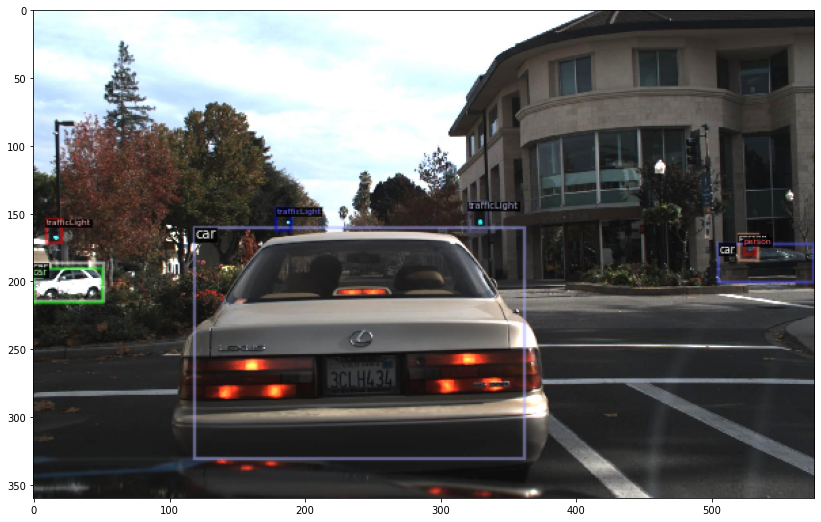

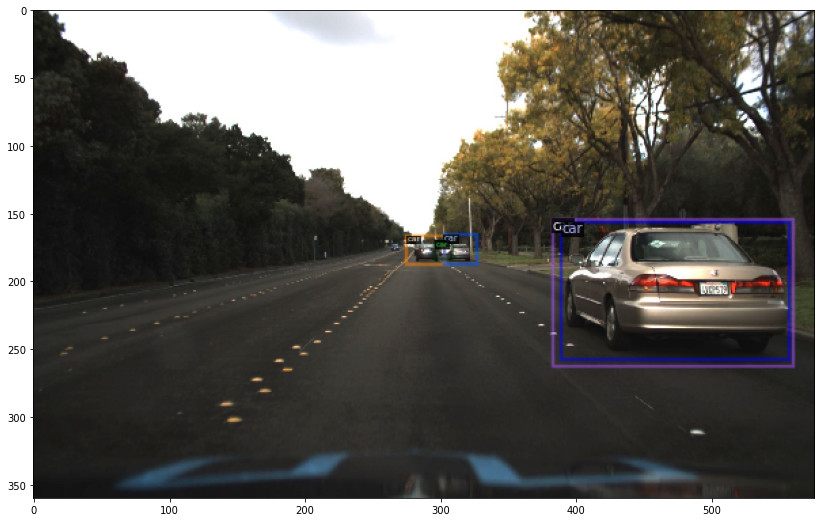

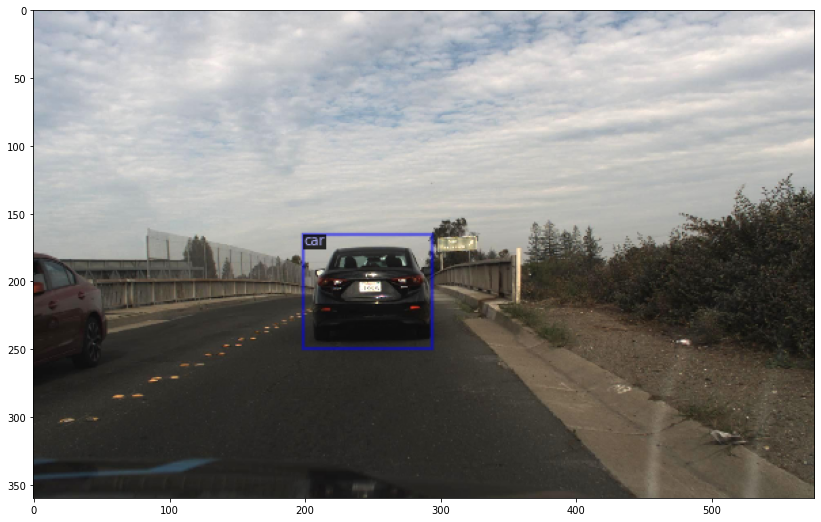

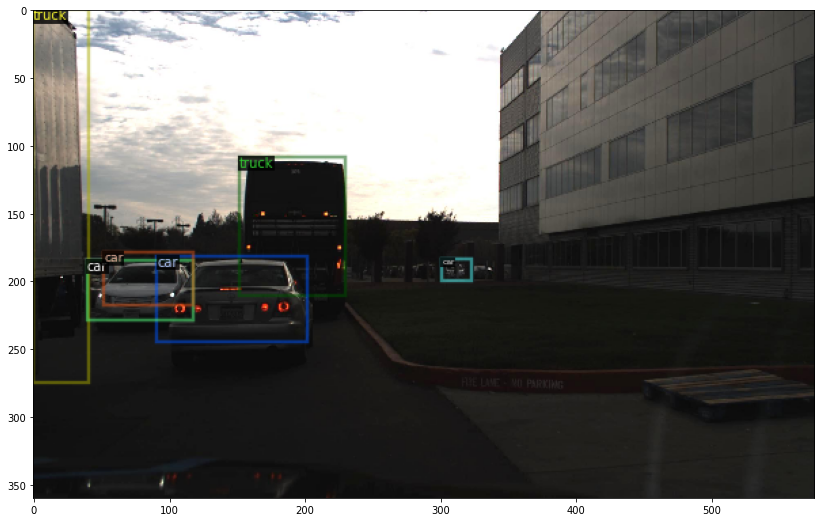

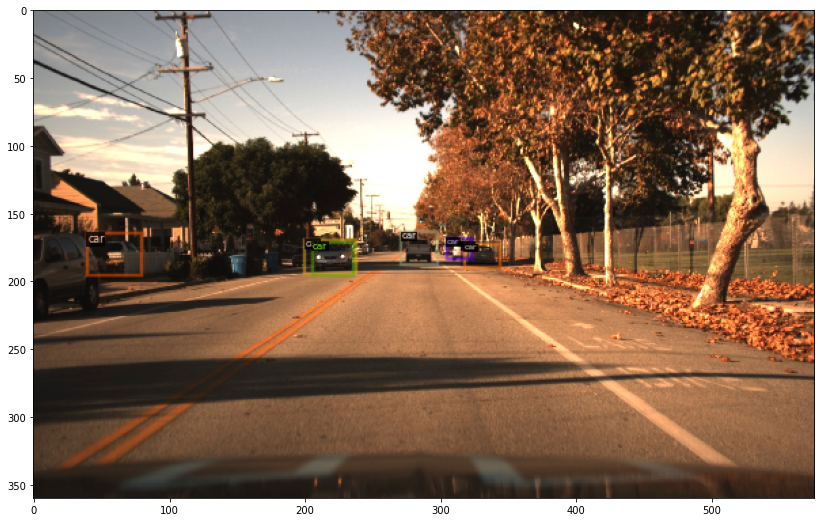

In [ ]:
dataset_dicts = DatasetCatalog.get('dl_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata= vehicle_detection_metadata, scale=0.3)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [16]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_CONFIG_FILE))
cfg.DATASETS.TRAIN = ('dl_vehicle_detection',)
cfg.DATASETS.TEST = ('test_vehicle',)   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR= (OUTPUT_DIR)
cfg.MODEL.WEIGHTS = (model_zoo.get_checkpoint_url(MODEL_CONFIG_FILE))
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 500
cfg.SOLVER.BASE_LR = 0.05 
cfg.SOLVER.STEPS = [700, 800]     
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)

[05/19 09:05:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.


In [17]:
trainer.train()

[05/19 09:06:29 d2.engine.train_loop]: Starting training from iteration 0
[05/19 09:07:10 d2.utils.events]:  eta: 1:07:17  iter: 19  total_loss: 2.241  loss_cls: 1.637  loss_box_reg: 0.469  loss_rpn_cls: 0.03289  loss_rpn_loc: 0.04645  time: 1.9895  data_time: 0.0650  lr: 5.855e-05  max_mem: 3882M
[05/19 09:07:52 d2.utils.events]:  eta: 1:08:01  iter: 39  total_loss: 1.451  loss_cls: 0.8339  loss_box_reg: 0.4608  loss_rpn_cls: 0.03432  loss_rpn_loc: 0.04483  time: 2.0364  data_time: 0.0070  lr: 6.755e-05  max_mem: 3882M
[05/19 09:08:33 d2.utils.events]:  eta: 1:07:02  iter: 59  total_loss: 0.8455  loss_cls: 0.4052  loss_box_reg: 0.3679  loss_rpn_cls: 0.02846  loss_rpn_loc: 0.03858  time: 2.0282  data_time: 0.0079  lr: 7.655e-05  max_mem: 3882M
[05/19 09:09:13 d2.utils.events]:  eta: 1:06:29  iter: 79  total_loss: 1.12  loss_cls: 0.4879  loss_box_reg: 0.5639  loss_rpn_cls: 0.02145  loss_rpn_loc: 0.04683  time: 2.0238  data_time: 0.0074  lr: 8.555e-05  max_mem: 3882M
[05/19 09:09:54 d2.u

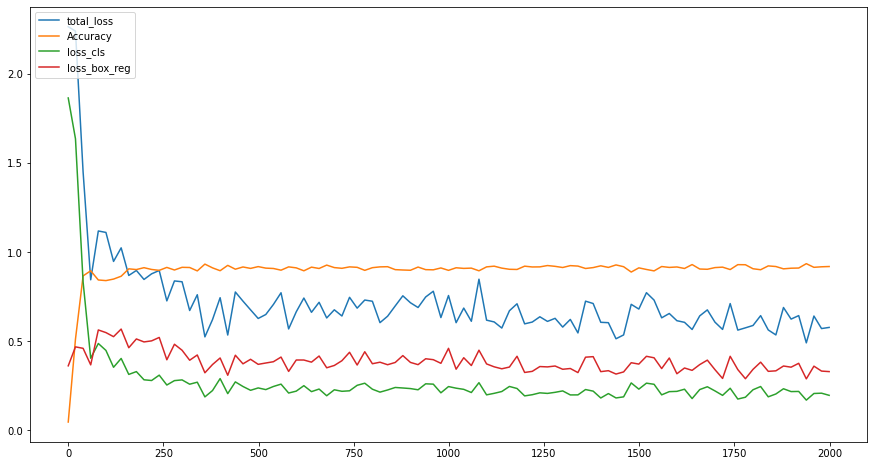

In [18]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r', encoding="utf8" ) as f:
       for line in f:
          lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(os.path.join(OUTPUT_DIR, 'metrics.json', ))
plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics ], 
    [x["fast_rcnn/cls_accuracy"] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics ], 
    [x["loss_cls"] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics ], 
    [x["loss_box_reg"] for x in experiment_metrics])
plt.legend(['total_loss', 'Accuracy', 'loss_cls', 'loss_box_reg'], loc='upper left')

In [21]:
cfg.DATASETS.TEST= ("test_vehicle",)
predictor = DefaultPredictor(cfg)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
evaluator = COCOEvaluator("test_vehicle", ("bbox",), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "test_vehicle")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[05/19 10:19:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/19 10:19:54 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[05/19 10:19:54 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/19 10:19:54 d2.evaluation.evaluator]: Start inference on 100 images
[05/19 10:20:00 d2.evaluation.evaluator]: Inference done 11/100. 0.4820 s / img. ETA=0:00:43
[05/19 10:20:05 d2.evaluation.evaluator]: Inference done 22/100. 0.4819 s / img. ETA=0:00:37
[05/19 10:20:11 d2.evaluation.evaluator]: Inference done 33/100. 0.4835 s / img. ETA=0:00:32
[05/19 10:20:16 d2.evaluation.evaluator]: Inference done 44/100. 0.4830 s / img. ETA=0:00:27
[05/19 10:20:21 d2.evaluation.evaluator]: Inference done 55/100. 0.4833 s / img. ETA=0:00:21
[05/19 10:20:27 d2.evaluation.evaluator]: Inference done 66/100. 0.4834 s / img. ETA=0:00:16
[05/19 10:20:32 d2.

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.68 µs


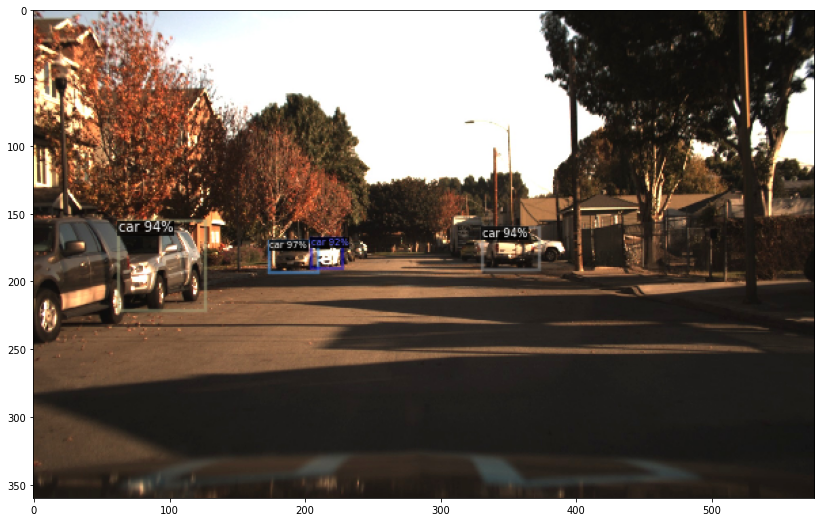

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


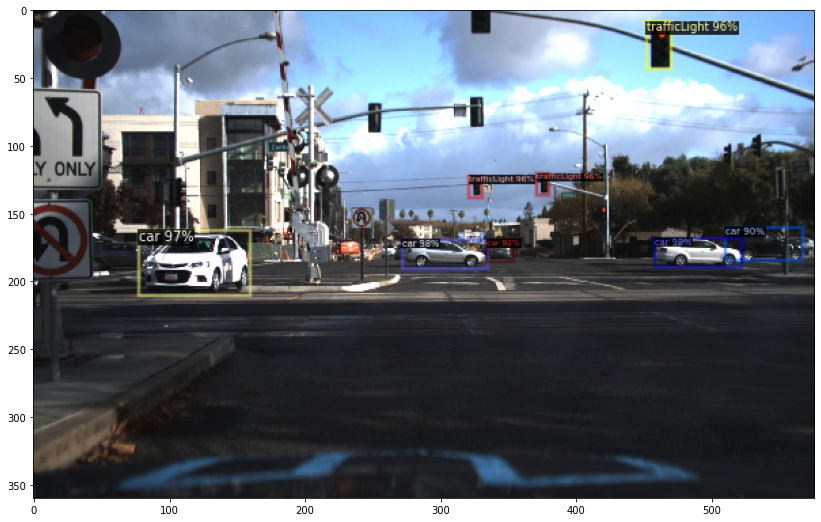

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


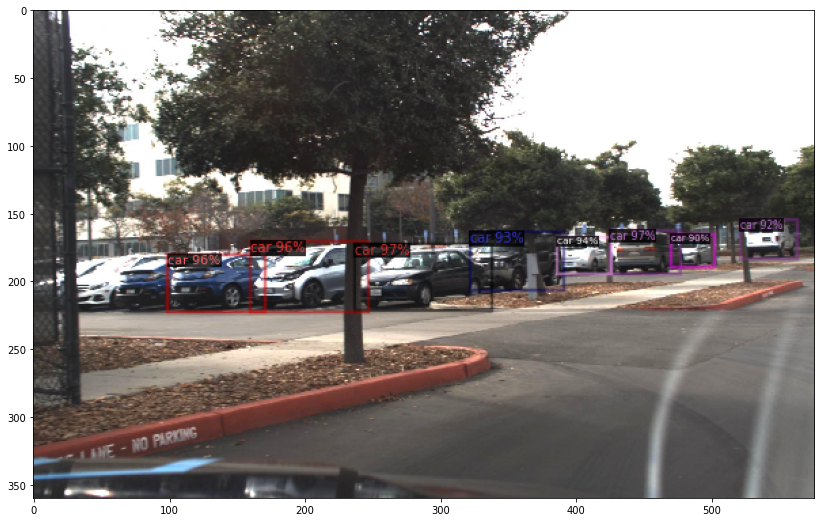

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 21.2 µs


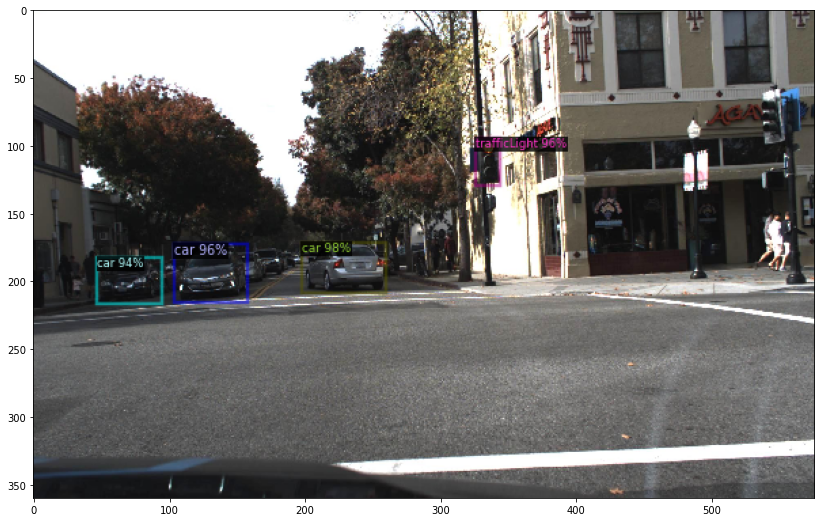

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


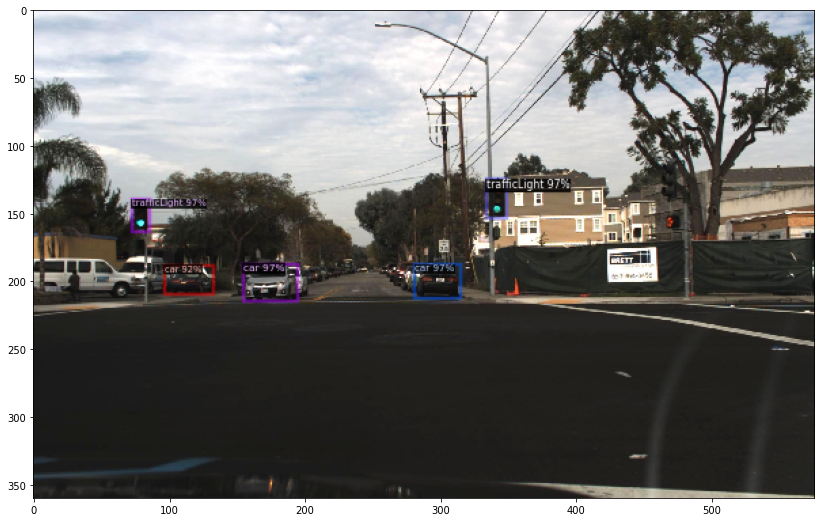

In [22]:
dataset_dicts = DatasetCatalog.get('test_vehicle',)
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=action_metadata1, scale=0.3)
    %time
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()